# Stage 1

In [1]:
import numpy as np

from mimesis import Person
from mimesis.providers.payment import Payment
from mimesis.enums import Gender, CardType

In [2]:
from scipy import stats
import pandas as pd
from itertools import cycle
from datetime import datetime
from datetime import timedelta
import calendar
import re

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
RANDOM_SEED = 2004

In [4]:
class DataGenerator:

    @staticmethod
    def generate_personal_data(num_records):
        person = Person('en')
        payment = Payment()

        dtype = np.dtype([
            ('id', np.unicode_, 16),
            ('full_name', np.unicode_, 32),
            ('credit_card_number', np.unicode_, 32),
            ('credit_card_expiration_date', np.unicode_, 8),
            ('gender', np.unicode_, 1),
            ('loan', np.float32)
        ])

        np.random.seed(RANDOM_SEED)
        rng = np.random.randint(0, 2, num_records)

        records_npy = np.empty(num_records, dtype=dtype)
        for idx in range(num_records):
            gender = Gender.MALE if rng[idx] == 0 else Gender.FEMALE
            records_npy['id'][idx] = str('{:016d}'.format(idx))
            records_npy['full_name'][idx] = person.full_name(gender=gender)
            records_npy['credit_card_number'][idx] = payment.credit_card_number(card_type=CardType.VISA)
            records_npy['credit_card_expiration_date'][idx] = payment.credit_card_expiration_date(
                maximum=25, minimum=20)
            records_npy['gender'][idx] = 'M' if rng[idx] == 0 else 'F'
        records_npy['loan'] = np.random.uniform(low=1000, high=100000, size=num_records)
        
        records_npy = records_npy[:num_records]

        return records_npy


if __name__ == '__main__':

    data = DataGenerator.generate_personal_data(1000)


Generate input data that contains the next columns:

1. full_name - random first and second name (using memesis library). Can be male or female
2. credit_card_number - random VISA format ID (using memesis library)
3. credit_card_expiration_date - month/year the range between 01/2020 and 01/2025 (using memesis library)
4. gender - MALE/FEMALE
4. loan - a random floating point number uniformly distributed in the range between 1000 and 100000 and minimum step 1000

In [5]:
def validate_input_data(input_data):
    """Check correspondence of input values data to the defined format."""
    fail_message = 'Warning. Failed to fit the format!\n'
    success_message = 'Success!\n'
    
    print('Check credit_card_expiration_date...')
    dates_patterns = [bool(re.match('^[0-1][0-9]/[2][0-5]$', card_exp_date)) for 
                      (record_id, name, card_numb, card_exp_date, gender, loan) in data]
    if np.all(dates_patterns):
        print(success_message)
    else:
        print(fail_message)
    
    print('Check gender column...')
    gender_col_vals = set(gender for (record_id, name, card_numb, card_exp_date, gender, loan) in input_data)
    if len(gender_col_vals) == 2 and [val for val in gender_col_vals if val.lower() in ['f', 'm']]:
        print(success_message)
    else:
        print(fail_message)
        
    print('Check loan column...')
    loan_col_vals = np.array([loan for (record_id, name, card_numb, card_exp_date, gender, loan) 
                                in input_data])
    if np.all(loan_col_vals > 1000) and np.all(loan_col_vals < 100000):
        print(success_message)
    else:
        print(fail_message)
    
    
validate_input_data(data)

Check credit_card_expiration_date...
Success!

Check gender column...
Success!

Check loan column...
Success!



In [6]:
#Check whether loan values are uniformly distributed
kstest_res_on_loan_col = stats.kstest(
    np.array([loan for (record_id, name, card_numb, card_exp_date, gender, loan) in data]), 
    stats.uniform(loc=1000, scale=100000).cdf
)
ks_statistic, p_value = kstest_res_on_loan_col.statistic, kstest_res_on_loan_col.pvalue

#Kolmogorov-Smirnov test helps to check similarity of distributions
print('Value of significance =', ks_statistic, 'P-value = ', p_value, 
      '\nIt shows that generated uniform distribution is close to distribution of loans',
      'because p-value is close to 1')

Value of significance = 0.016942460937499987 P-value =  0.9363853437255386 
It shows that generated uniform distribution is close to distribution of loans because p-value is close to 1


Data requirements:

1. There should be up to 12 records with the same full_name while the other data can be different. A particular number of such records should be uniformly distributed
2. The user-defined random number seed should be used to generate the same data again if you define the same seed. 
3. Data should be saved into a CSV file: 
InputData_YYYYMM_SEED_YYYYMMDDHHMMSS.csv, 
here YYYYMM - valuation_date (e.g. 2020/01), 
SEED - random number generator seed (see #2),
YYYYMMDDHHMMSS - timestamp of the moment when the file was published on the file system
4. The number of records is not limited but should be statistically representative


In [7]:
def generate_duplicated_names(input_data, reduce_to_percent=0.8):
    names = np.array([name for (record_id, name, card_numb, card_exp_date, gender, loan) in input_data])
    if names.size == np.unique(names).size:
        print('Data has no duplicates in the full name columns. Generating duplicates...')
        ids, names, card_numbs, card_dates, genders, loans = zip(*input_data)
        reduced_names_set = names[:int(len(names)*reduce_to_percent)]
        return np.array(tuple(list(
            zip(ids, cycle(reduced_names_set), card_numbs, card_dates, genders, loans))
        ))
    else:
        print('Data has records with duplicated full names.')
        return input_data
    
data = generate_duplicated_names(data)

Data has no duplicates in the full name columns. Generating duplicates...


In [8]:
stage_mapping_to_filename = {1: {'filename': 'InputData', 'extension': 'csv'}, 
                             2: {'filename': 'MappedInputData', 'extension': 'npy'}, 
                             3: {'filename': 'LoanData', 'extension': 'npy'}}

def save_data(data_to_save, stage_number, random_seed=RANDOM_SEED):
    file_info_per_stage = stage_mapping_to_filename.get(stage_number)
    date_published = datetime.now().strftime("%Y%m%d%H%M%S")
    valuation_date = datetime.now().strftime("%Y%m")
    
    np.savetxt('{filename}_{valuation_date}_{seed}_{date_published}.{file_extension}'.format(
        filename=file_info_per_stage.get('filename'), file_extension=file_info_per_stage.get('extension'),
        valuation_date=valuation_date, seed=random_seed, date_published=date_published
    ), X=data_to_save, delimiter=',', fmt="%s")

# Stage 2

Data extraction, transformation and validation

A Numpy array of records should be created:

1. user_id - integer number (primary key, an identity of the user)
2. gender - integer number
3. expiration_date - integer year, integer month and integer day (end-of-month). Should be present as special numpy dtype
3. loan - floating point number array with a size 10 (number of payment programs)

Some separate tables will be useful too:
1. Mapping of the user_name to user_id (or backward)
2. Mapping of gender real name to its integer representation
3. Assuming we have 10 payment programs we can create a mapping of their ids to their names (e.g. P0, P2 etc. or any other unique names)

In [9]:
def generate_data(num_records):
        person = Person('en')
        payment = Payment()
        
        array_size = 10
                
        dtype = np.dtype([
            ('user_name', np.unicode_, 32),
            ('user_id', np.unicode_, 32),
            ('expiration_date', np.unicode_, 8),
            ('gender', np.unicode_, 1),
            ('gender_int', np.unicode_, 1),
            ('loan', np.float64, (array_size,))
        ])

        np.random.seed(RANDOM_SEED)
        rng = np.random.randint(0, 2, num_records)

        records_npy = np.empty(num_records, dtype=dtype)
        for idx in range(num_records):
            gender = Gender.MALE if rng[idx] == 0 else Gender.FEMALE
            records_npy['user_name'][idx] = person.full_name(gender=gender)
            records_npy['user_id'][idx] = payment.credit_card_number(card_type=CardType.VISA)
            records_npy['expiration_date'][idx] = payment.credit_card_expiration_date(
                maximum=25, minimum=20, )
            records_npy['gender'][idx] = 'M' if rng[idx] == 0 else 'F'
            records_npy['gender_int'][idx] = rng[idx]
            records_npy['loan'][idx] = np.random.uniform(low=1000, high=100000, size=array_size)
        
        records_npy = records_npy[:num_records]

        return records_npy

def form_data_tables(generated_data):
    """Preprocess generated data and form distinct tables."""
    user_names, user_ids, cards_exp_dates, gender, gender_int, loans = zip(*generated_data)
    
    #add last day of month to the dates
    cards_exp_dates = ['{day}/{month}/{year}'.format(
        day=calendar.monthrange(int('20{}'.format(year)), int(month))[1], 
        month=month, year=year
    ) for month, year in [str_date.split('/') for str_date in cards_exp_dates]]
    
    records_table = convert_zip_objects_to_array(zip(user_ids, gender, cards_exp_dates, loans))
    user_names_table = convert_zip_objects_to_array(zip(user_ids, user_names))
    genders_table = np.unique(
        convert_zip_objects_to_array(
            zip(gender_int, gender)
        ), axis=0)
    payment_programs_table = np.array(
        [('P{program_numb}'.format(program_numb=program_numb), program_numb) for program_numb in range(10)])
    
    return records_table, user_names_table, genders_table, payment_programs_table

def convert_zip_objects_to_array(zip_object):
    """Convert zip object to numpy array."""
    return np.array(tuple(list(zip_object)))

In [34]:
init_data = generate_data(200)
records, user_names, genders, payment_programs = form_data_tables(init_data)

In [35]:
genders

array([['0', 'M'],
       ['1', 'F']], dtype='<U1')

In [36]:
payment_programs

array([['P0', '0'],
       ['P1', '1'],
       ['P2', '2'],
       ['P3', '3'],
       ['P4', '4'],
       ['P5', '5'],
       ['P6', '6'],
       ['P7', '7'],
       ['P8', '8'],
       ['P9', '9']], dtype='<U2')

Validation
1. All users having repeatable records should be excluded if occurred in the initial file more 10 times. 
2. Such (#1) user_names should be stored in the invalid_user_list (can be numpy array of Unicode strings)


In [37]:
invalid_user_list = np.empty([])

def delete_repeatable_records(data, max_allowed_repitions=10):
    data_as_df = pd.DataFrame(data)
    data_as_df.columns = ['user_id', 'gender', 'exp_date', 'loan']
    duplicates = data_as_df.reset_index(drop=False).astype(str).groupby(
        data_as_df.columns.to_list()).count().rename(columns={'index':'n_repeated_records'}).reset_index()
    
    duplicated_user_ids = duplicates[duplicates['n_repeated_records'] > max_allowed_repitions]['user_id']
    invalid_user_list = np.array(duplicated_user_ids)
    
    clean_df_from_duplicates = pd.concat([
        data_as_df[data_as_df['user_id'].isin(duplicated_user_ids)].drop_duplicates(['user_id']),
        data_as_df[~data_as_df['user_id'].isin(duplicated_user_ids)]
    ])
    
    return np.array(clean_df_from_duplicates)

records = delete_repeatable_records(records)

Fill in loan columns
1. The id_program is defined by the incremental sum of all digits in VISA id of the record until you get a one-digit number
2. Loans with the same id_program received from different records should be aggregated (sum)

The result can be saved to MappedInputData_YYYYMM_SEED_YYYYMMDDHHMMSS.npy. Notice, YYYYMM_SEED_YYYYMMDDHHMMSS should be equal to CSV one so we can always track the sources

In [38]:
def get_incremental_sum(digits_list):
    """Get cumilative sum of provided list of digits. Sum digits until one-digit number is provided as a result"""
    inc_sum = 0            
    for i in range(len(digits_list)):
        if inc_sum + digits_list[i] < 10:
            inc_sum = inc_sum + digits_list[i] 
        else:
            break
    
    return inc_sum

def fill_loan_columns(data):
    """Add program id and aggregated sum to the records"""
    card_digits = [[int(digit) for digit in list(card_numb.replace(' ', ''))] for card_numb in data[:, 0]]
    id_program_list = np.array([[get_incremental_sum(digits)] for digits in card_digits])
    data_with_sum = np.concatenate((data, id_program_list), axis=1)
    
    aggr_sum_per_program, loans_sums = aggregate_sums(data_with_sum)
    res_as_df = pd.DataFrame(data_with_sum, columns=['user_id', 'gender', 'exp_date', 'loans', 'program_id']
                            ).merge(
        pd.DataFrame(aggr_sum_per_program, columns=['program_id', 'aggr_sum']))
    res_as_df['loans_sums'] = loans_sums
    
    return np.array(res_as_df)

def aggregate_sums(data):    
    """Aggregating loans with same id program from different records."""
    loans_sums = np.array([sum(loans_arr) for loans_arr in data[:, 3]])
    loans_programs_per_user = np.array(list(zip(loans_sums, data[:, 4])))
      
    uniq_payment_programs = np.unique(data[:, 4])
    aggr_sum_per_program = [(
        program_id, 
        loans_programs_per_user[loans_programs_per_user[:, 1] == program_id][:, 0].sum()
    ) for program_id in uniq_payment_programs]
        
    return aggr_sum_per_program, loans_sums

In [39]:
records_with_pay_programs = fill_loan_columns(records)

# Stage 3. Simulation and Analysis

Assumptions (This data can be stored in numpy arrays):

standard_monthly_payment_rate = 1E-4
mortality_correction_for_payment_rate = MALE: 1.01, FEMALE: 0.99
fixed_to_floating_limit = 700000 
standard_deviation_for_flaoting_rate = P0: 0.01, P2: 0.01 ... P9: 0.09 (different for each program)\

In [40]:
standard_monthly_payment_rate = np.array(1e-4)
fixed_to_floating_limit = 700000 

mortality_correction_for_payment_rate = {'M': 1.01, 'F': 0.99}
#np.array(list({'M': 1.01, 'F': 0.99}.items()))

standard_deviation_for_floating_rate = dict(
    zip(payment_programs[:, 0],
    [rate / 100 for rate in np.random.randint(10, 90, 20)])
)

Calculation:

1. For each user record we do the projection starting from valuation_date (01/19) to the expiration_date
2. Each projection step is equal to one month
3. Loan on each step is an accumulated sum of current loan value + payment
4. Payment is calculated as the previous loan multiplied by payment rate and corresponding mortality correction
5. A standard rate can be floating or fixed depending on the total loan (sum of all 10 programs) of the user account (record). If a total loan is less than a limit then it is fixed otherwise it is floating
6. The floating payment rate is calculated as a random number generated by log-normal distribution with expected value equal to standard rate and corresponding stdev
7. user_id should be a seed of the random number generator used in #6
8. Each floating period should be calculated using 100 random number sequences (scenarios)

The result should be an array of loans with the size number of programs x number of scenarios (10 x 100). These results should be saved to LoanData_YYYYMM_SEED_YYYYMMDDHHMMSS.npy


In [17]:
def get_payment_rate(user_id, program_name, loans_sum):
    """Get payment rate for the record based on loans sum."""
    if loans_sum >= fixed_to_floating_limit:
        np.random.seed(int(user_id.replace(' ', '')) % 10000)
        #otherwise ValueError: Seed must be between 0 and 2**32 - 1
        st_dev = standard_deviation_for_floating_rate.get(program_name)
        return np.random.lognormal(
            mean=standard_monthly_payment_rate, sigma=st_dev, size=1)
    else:
        return standard_monthly_payment_rate

In [41]:
def get_projections(records_data):
    projections, expected_values = [], []
    for val in records_data:
        payment_program_name = payment_programs[payment_programs[:, 1] == str(val[4])][:, 0][0]
        expected_values.append(standard_deviation_for_floating_rate.get(payment_program_name))
        projections.append(np.array([
            float(
                cur_loan + get_payment(val[0], get_previos_loan(i, val[3]), val[6], payment_program_name, val[1]))
            for i, cur_loan in enumerate(val[3])
        ]))
    records_data_with_projections = pd.DataFrame(records_data)
    records_data_with_projections['projections'] = projections
    records_data_with_projections['expected_values'] = expected_values
    return np.array(records_data_with_projections)
        
def get_previos_loan(cur_loan_index, loans_list):
    """Get previous loan value for current loan."""
    if cur_loan_index > 0:
        if cur_loan_index < len(loans_list):
            return loans_list[cur_loan_index-1]
        else:
            raise IndexError('List index out of range')
    else:
        return None
    
def get_payment(user_id, prev_loan, loans_sum, program_name, gender):
    """Caclulate value of the payment for the step."""
    if prev_loan:
        payment_rate = get_payment_rate(user_id, program_name, loans_sum)
        mortality_correction = mortality_correction_for_payment_rate.get(gender)
        return prev_loan*payment_rate*mortality_correction
    else:
        return 0

In [42]:
records_with_projections = get_projections(records_with_pay_programs)

Test task has insufficient data for making the projection - it lacks dates of loans so it would be possible to evaluate at each time step which loan is considered to be current and the payments could be calculated correspondingly

In [72]:
save_data(data, 1)
save_data(records_with_pay_programs, 2)
save_data(records_with_projections, 3)

# Analysis

1. Plot histogram for each program and total 
2. Calculate corresponding Expected Values and 5%, 25%, 75%, 95% Quantiles

In [69]:
def plot_hist(programs_aggr_sums, plot_opacity=0.4,
             figwidth=7, figheight=4):
    total_programs_sum = programs_aggr_sums.sum()
    program_info_to_plot = list(programs_aggr_sums)
    
    fig, ax = plt.subplots(figsize=(figwidth, figheight))
    plt.hist(program_info_to_plot, facecolor='blue', alpha=plot_opacity)
    plt.show()
    plt.hist(total_programs_sum)
    plt.title('Total')
    plt.show()

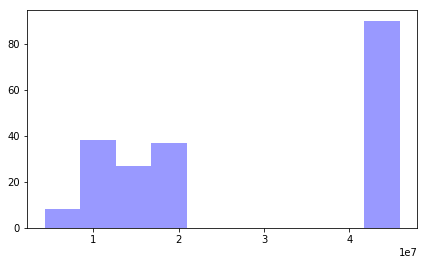

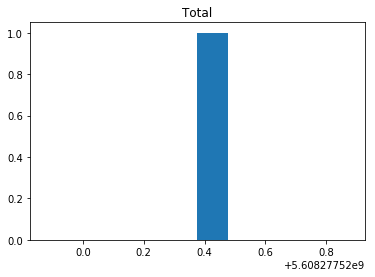

In [70]:
plot_hist(records_with_projections[:, 5])

In [71]:
pd.DataFrame(records_with_projections[:, 8], columns=['expected_values']
            ).reset_index(drop=False
                         ).describe(percentiles=[0.5, 0.25, 0.75, 0.95])

,index
count,200.000000
mean,99.500000
std,57.879185
min,0.000000
25%,49.750000
50%,99.500000
75%,149.250000
95%,189.050000
max,199.000000
